# Load Data

In [ ]:
# Mount your Google Drive.
from google.colab import drive
drive.mount("/content/drive")
kaggle_creds_path = "/content/drive/My Drive/kaggle.json"

! pip install kaggle --quiet
! mkdir ~/.kaggle
! cp "/content/drive/My Drive/kaggle.json" ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [ ]:
# Kaggle api command
! kaggle competitions download -c nlp-getting-started

100% 593k/593k [00:00<00:00, 3.38MB/s]
100% 593k/593k [00:00<00:00, 3.37MB/s]


In [ ]:
! unzip {"nlp-getting-started.zip"} -d kaggle_data

Archive:  nlp-getting-started.zip
  inflating: kaggle_data/sample_submission.csv  
  inflating: kaggle_data/test.csv    
  inflating: kaggle_data/train.csv   


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from scipy.stats import probplot
from matplotlib.ticker import MaxNLocator
%matplotlib inline

from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from wordcloud import WordCloud
from collections import Counter
from textblob import TextBlob
import spacy
#import emoji
import regex as re
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('wordnet2022')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package wordnet2022 to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet2022.zip.


True

In [ ]:
df_train = pd.read_csv("kaggle_data/train.csv", index_col='id')
df_test = pd.read_csv("kaggle_data/test.csv", index_col='id')

print('Training Set Shape = {}'.format(df_train.shape))
print('Test Set Shape = {}'.format(df_test.shape))

df_train.head()


Training Set Shape = (7613, 4)
Test Set Shape = (3263, 3)


,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Text Preprocessing

In [ ]:
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def clean_text(txt):
    """
    cleans the input text by following the steps:
    * replace contractions
    * remove punctuation
    * split into words
    * remove stopwords
    * remove leftover punctuations
    """
    contraction_dict = {
        "ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because",
        "could've": "could have", "couldn't": "could not", "didn't": "did not",
        "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not",
        "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is",
        "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have"
    }

    def _get_contractions(contraction_dict):
        contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
        return contraction_dict, contraction_re

    def replace_contractions(text):
        contractions, contractions_re = _get_contractions(contraction_dict)
        def replace(match):
            return contractions[match.group(0)]
        return contractions_re.sub(replace, text)

    # replace contractions
    txt = replace_contractions(txt)

    # remove punctuations
    txt  = "".join([char for char in txt if char not in string.punctuation])
    # remove numbers
    txt = re.sub('[0-9]+', '', txt)
    # convert to lowercase
    txt = txt.lower()
    # replace hashtags
    txt = re.sub(r"\#", "", txt)
    # remove URL addresses
    txt = re.sub(r"http\S+", "URL", txt)
    # remove @ symbols
    txt = re.sub(r"@", "", txt)
    # remove multiple contiguous spaces
    txt = re.sub(r"\s{2,}", " ", txt)

    # split into words
    words = word_tokenize(txt)

    # remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]

    # removing leftover punctuations
    words = [word for word in words if word.isalpha()]

    cleaned_text = ' '.join(words)
    return cleaned_text

# clean train and test tweets
df_train['text'] = df_train['text'].apply(lambda txt: clean_text(txt))
df_test['text'] = df_test['text'].apply(lambda txt: clean_text(txt))

In [ ]:
df_train.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,deeds reason earthquake may allah forgive us,1
4,NaN,NaN,forest fire near la ronge sask canada,1
5,NaN,NaN,residents asked shelter place notified officer...,1
6,NaN,NaN,people receive wildfires evacuation orders cal...,1
7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


# USE model
Universal Sentence Embedding\
[참고](https://sandipanweb.wordpress.com/2023/03/31/nlp-disaster-tweets-kaggle-mini-project/)



## using just text (0.80570)

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
transfer_model_url = 'https://tfhub.dev/google/universal-sentence-encoder-cmlm/en-base/1'
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],  # shape of inputs coming to our model
                                        dtype=tf.string,  # data type of inputs coming to the USE layer
                                        trainable=False,
                                        # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

model_use = tf.keras.Sequential([
    sentence_encoder_layer,
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
    ], name = 'transfer_mode')

model_use.summary()

Model: "transfer_mode"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 16)                8208      
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 256806321 (979.64 MB)
Trainable params: 8497 (33.19 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
from sklearn.model_selection import train_test_split
X, y = df_train['text'].values, df_train['target'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)
X.shape, y.shape

((7613,), (7613,))

In [ ]:
model_use.compile(loss = tf.keras.losses.BinaryCrossentropy(),
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             metrics=['accuracy',tf.keras.metrics.AUC()])

In [ ]:
def plot_hist(hist):
    '''
    Plots the training / validation loss and accuracy given the training history
    '''
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history['val_accuracy'])
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title("Model Evaluation")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])
    plt.grid()
    plt.show()

In [ ]:
%%time
history = model_use.fit(X_train, y_train,
                        epochs = 10,
                        validation_data=(X_val, y_val))

Epoch 1/10
179/179 [==============================] - 6s 16ms/step - loss: 0.5842 - accuracy: 0.7171 - auc_11: 0.7887 - val_loss: 0.4526 - val_accuracy: 0.7952 - val_auc_11: 0.8712
Epoch 2/10
179/179 [==============================] - 4s 21ms/step - loss: 0.4419 - accuracy: 0.8014 - auc_11: 0.8675 - val_loss: 0.4292 - val_accuracy: 0.8025 - val_auc_11: 0.8762
Epoch 3/10
179/179 [==============================] - 3s 17ms/step - loss: 0.4249 - accuracy: 0.8103 - auc_11: 0.8770 - val_loss: 0.4264 - val_accuracy: 0.8157 - val_auc_11: 0.8761
Epoch 4/10
179/179 [==============================] - 2s 13ms/step - loss: 0.4131 - accuracy: 0.8152 - auc_11: 0.8831 - val_loss: 0.4287 - val_accuracy: 0.8067 - val_auc_11: 0.8776
Epoch 5/10
179/179 [==============================] - 5s 26ms/step - loss: 0.4145 - accuracy: 0.8135 - auc_11: 0.8830 - val_loss: 0.4285 - val_accuracy: 0.8151 - val_auc_11: 0.8754
Epoch 6/10
179/179 [==============================] - 3s 18ms/step - loss: 0.4044 - accuracy: 0

accuracy: 0.8324\
val_accuracy: 0.8104

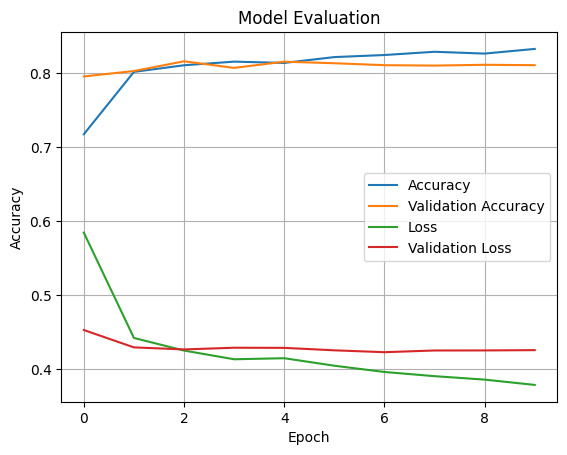

In [ ]:
plot_hist(history)

In [ ]:
# prediction
X_test = df_test['text'].values
predictions_prob = model_use.predict(X_test)
predictions = tf.round(predictions_prob)

102/102 [==============================] - 1s 8ms/step


In [ ]:
submission = pd.read_csv('/content/kaggle_data/sample_submission.csv')
submission['target'] = predictions
submission['target'] =submission['target'].astype(int)
submission['id'] = df_test.index
submission.to_csv('submission.csv', index=False)
submission.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1


kaggle: 0.80570

## using text & keyword inputs (0.80845)
- nan인 row들 따로 값 너어주고 test도 똑같이 전처리
- Prepare the inputs: You need to handle the text and keyword inputs separately. The text input will go through the USE layer, while the keyword input will go through its own processing layer.

In [ ]:
df_train2 = df_train.copy()
df_train2['keyword'].fillna('nan', inplace=True)
print(df_train2['keyword'].isnull().sum())
df_train2.head()

0


,keyword,location,text,target
id,,,,
1,nan,NaN,deeds reason earthquake may allah forgive us,1
4,nan,NaN,forest fire near la ronge sask canada,1
5,nan,NaN,residents asked shelter place notified officer...,1
6,nan,NaN,people receive wildfires evacuation orders cal...,1
7,nan,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [ ]:
df_test2 = df_test.copy()
df_test2['keyword'].fillna('nan', inplace=True)
df_test2.head()

,keyword,location,text
id,,,
0,nan,NaN,happened terrible car crash
2,nan,NaN,heard earthquake different cities stay safe ev...
3,nan,NaN,forest fire spot pond geese fleeing across str...
9,nan,NaN,apocalypse lighting spokane wildfires
11,nan,NaN,typhoon soudelor kills china taiwan


In [ ]:
from sklearn.model_selection import train_test_split
# Prepare data
X_text = df_train2['text'].to_numpy()
X_keyword = df_train2['keyword'].to_numpy()
test_text = df_test2['text'].to_numpy()
test_keyword = df_test2['keyword'].to_numpy()
y2 = df_train2['target'].to_numpy()

# Split data
X_text_train, X_text_val, X_keyword_train, X_keyword_val, y_train2, y_val2 = train_test_split(
    X_text, X_keyword, y2, test_size=0.25, random_state=42)

In [ ]:
print(df_train2['keyword'].nunique())

222


In [ ]:
# Convert keywords to integer indices (example mapping for demonstration purposes)
keyword_to_index = {k: i for i, k in enumerate(set(df_train2['keyword']))}
X_keyword_train_idx = np.array([keyword_to_index[k] for k in X_keyword_train])
X_keyword_val_idx = np.array([keyword_to_index[k] for k in X_keyword_val])
# test
test_keyword_idx = np.array([keyword_to_index[k] for k in test_keyword])

In [ ]:
# Convert text and keyword inputs to dictionary format
train_data = {'text': X_text_train, 'keyword': X_keyword_train_idx}
val_data = {'text': X_text_val, 'keyword': X_keyword_val_idx}
# test
test_data = {'text': test_text, 'keyword': test_keyword_idx}

In [ ]:
# Check the keys in the dictionary
print("Keys in train_data:", train_data.keys())

# Check the type and shape of each value
for key, value in train_data.items():
    print("Feature:", key)
    print("Type:", type(value))
    print("Shape:", value.shape if isinstance(value, np.ndarray) else "Not a NumPy array")

Keys in train_data: dict_keys(['text', 'keyword'])
Feature: text
Type: <class 'numpy.ndarray'>
Shape: (5709,)
Feature: keyword
Type: <class 'numpy.ndarray'>
Shape: (5709,)


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
transfer_model_url = 'https://tfhub.dev/google/universal-sentence-encoder-cmlm/en-base/1'
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],  # shape of inputs coming to our model
                                        dtype=tf.string,  # data type of inputs coming to the USE layer
                                        trainable=False,
                                        # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")
from tensorflow.keras.layers import Input

# Define text input
text_input = Input(shape=(), dtype=tf.string, name='text')
text_embedding = sentence_encoder_layer(text_input)

In [ ]:
# Assuming X_keyword_train is the keyword data for training
# Convert keyword data to a list
keyword_list = list(X_keyword_train)

# Calculate the vocabulary size
vocabulary_size = len(set(keyword_list))

print("Vocabulary size:", vocabulary_size)

Vocabulary size: 222


In [ ]:
from tensorflow.keras.layers import Reshape, Input, Dense, Dropout, Concatenate, Embedding, GlobalAveragePooling1D
# Define keyword input
keyword_input = Input(shape=(), dtype=tf.int32, name='keyword')
# input_dim = vocabulary_size + 1
keyword_embedding = Embedding(input_dim=vocabulary_size+1, output_dim=32)(keyword_input)
# Reshape the output of the Embedding layer to add a sequence length dimension
keyword_embedding = Reshape(target_shape=(1, 32))(keyword_embedding)
keyword_embedding = GlobalAveragePooling1D()(keyword_embedding)

In [ ]:
# Concatenate embeddings
combined = Concatenate()([text_embedding, keyword_embedding])

In [ ]:
# Add additional layers
x = Dropout(0.1)(combined)
x = Dense(16, activation="relu")(x)
x = Dense(16, activation="relu")(x)
output = Dense(1, activation="sigmoid")(x)

# Define the model
from tensorflow.keras.models import Model
model_use2 = Model(inputs=[text_input, keyword_input], outputs=output)

# Compile the model
model_use2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=['accuracy', tf.keras.metrics.AUC()])

# Model summary
model_use2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 keyword (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 embedding (Embedding)       (None, 32)                   7136      ['keyword[0][0]']             
                                                                                                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 reshape (Reshape)           (None, 1, 32)                0         ['embedding[0][0]']           
                                                                                            

In [ ]:
def plot_hist(hist):
    '''
    Plots the training / validation loss and accuracy given the training history
    '''
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history['val_accuracy'])
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title("Model Evaluation")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])
    plt.grid()
    plt.show()

In [ ]:
%%time
# Train the model
history2 = model_use2.fit(
    x=train_data,
    y=y_train2,
    validation_data=(val_data, y_val2),
    epochs=10,
    batch_size=32
)

Epoch 1/10
179/179 [==============================] - 6s 21ms/step - loss: 0.5647 - accuracy: 0.7478 - auc_1: 0.8139 - val_loss: 0.4604 - val_accuracy: 0.7978 - val_auc_1: 0.8725
Epoch 2/10
179/179 [==============================] - 5s 29ms/step - loss: 0.4164 - accuracy: 0.8173 - auc_1: 0.8878 - val_loss: 0.4241 - val_accuracy: 0.8157 - val_auc_1: 0.8822
Epoch 3/10
179/179 [==============================] - 4s 22ms/step - loss: 0.3960 - accuracy: 0.8266 - auc_1: 0.8968 - val_loss: 0.4219 - val_accuracy: 0.8220 - val_auc_1: 0.8832
Epoch 4/10
179/179 [==============================] - 3s 14ms/step - loss: 0.3867 - accuracy: 0.8292 - auc_1: 0.9014 - val_loss: 0.4198 - val_accuracy: 0.8230 - val_auc_1: 0.8835
Epoch 5/10
179/179 [==============================] - 3s 15ms/step - loss: 0.3805 - accuracy: 0.8334 - auc_1: 0.9040 - val_loss: 0.4177 - val_accuracy: 0.8262 - val_auc_1: 0.8848
Epoch 6/10
179/179 [==============================] - 4s 24ms/step - loss: 0.3724 - accuracy: 0.8346 - au

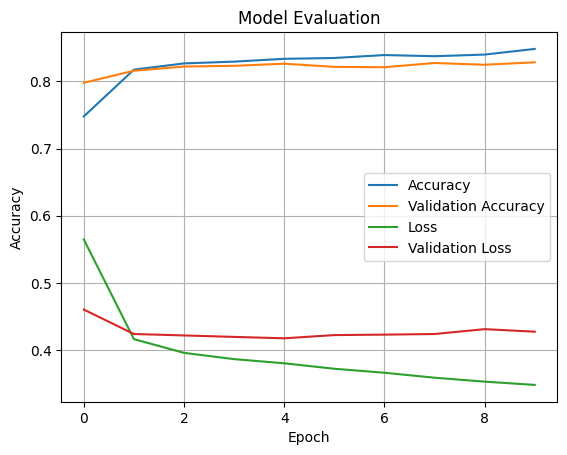

In [ ]:
plot_hist(history2)

In [ ]:
# prediction
predictions_prob2 = model_use2.predict(test_data)
predictions2 = tf.round(predictions_prob2)

102/102 [==============================] - 2s 11ms/step


In [ ]:
submission = pd.read_csv('/content/kaggle_data/sample_submission.csv')
submission['target'] = predictions2
submission['target'] =submission['target'].astype(int)
submission['id'] = df_test.index
submission.to_csv('submission.csv', index=False)
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [ ]:
!kaggle competitions submit -c nlp-getting-started -f /content/submission.csv -m "Message"

100% 22.2k/22.2k [00:00<00:00, 41.9kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets

0.80845

## leaving the text as a sentence (0.81182)

In [ ]:
import re
import string

def clean_text(txt):
    # remove punctuations
    txt  = "".join([char for char in txt if char not in string.punctuation])
    # remove numbers
    txt = re.sub('[0-9]+', '', txt)
    # convert to lowercase
    txt = txt.lower()
    # replace hashtags
    txt = re.sub(r"\#", "", txt)
    # remove URL addresses
    txt = re.sub(r"http\S+", "URL", txt)
    # remove @ symbols
    txt = re.sub(r"@", "", txt)
    # remove multiple contiguous spaces
    txt = re.sub(r"\s{2,}", " ", txt)

    return txt

# clean train and test tweets
df_train['text'] = df_train['text'].apply(lambda txt: clean_text(txt))
df_test['text'] = df_test['text'].apply(lambda txt: clean_text(txt))

In [ ]:
df_train.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,our deeds are the reason of this earthquake ma...,1
4,NaN,NaN,forest fire near la ronge sask canada,1
5,NaN,NaN,all residents asked to shelter in place are be...,1
6,NaN,NaN,people receive wildfires evacuation orders in...,1
7,NaN,NaN,just got sent this photo from ruby alaska as s...,1


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
transfer_model_url = 'https://tfhub.dev/google/universal-sentence-encoder-cmlm/en-base/1'
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],  # shape of inputs coming to our model
                                        dtype=tf.string,  # data type of inputs coming to the USE layer
                                        trainable=False,
                                        # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

model_use = tf.keras.Sequential([
    sentence_encoder_layer,
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
    ], name = 'transfer_mode')

model_use.summary()

Model: "transfer_mode"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 16)                8208      
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 256806321 (979.64 MB)
Trainable params: 8497 (33.19 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
from sklearn.model_selection import train_test_split
X, y = df_train['text'].values, df_train['target'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)
X.shape, y.shape

((7613,), (7613,))

In [ ]:
model_use.compile(loss = tf.keras.losses.BinaryCrossentropy(),
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             metrics=['accuracy',tf.keras.metrics.AUC()])

In [ ]:
def plot_hist(hist):
    '''
    Plots the training / validation loss and accuracy given the training history
    '''
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history['val_accuracy'])
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title("Model Evaluation")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])
    plt.grid()
    plt.show()

In [ ]:
%%time
history = model_use.fit(X_train, y_train,
                        epochs = 10,
                        validation_data=(X_val, y_val))

Epoch 1/10
179/179 [==============================] - 10s 33ms/step - loss: 0.5902 - accuracy: 0.6931 - auc: 0.7986 - val_loss: 0.4712 - val_accuracy: 0.8093 - val_auc: 0.8799
Epoch 2/10
179/179 [==============================] - 3s 17ms/step - loss: 0.4463 - accuracy: 0.8033 - auc: 0.8704 - val_loss: 0.4184 - val_accuracy: 0.8088 - val_auc: 0.8866
Epoch 3/10
179/179 [==============================] - 3s 15ms/step - loss: 0.4183 - accuracy: 0.8177 - auc: 0.8823 - val_loss: 0.4098 - val_accuracy: 0.8167 - val_auc: 0.8888
Epoch 4/10
179/179 [==============================] - 3s 16ms/step - loss: 0.4091 - accuracy: 0.8192 - auc: 0.8868 - val_loss: 0.4067 - val_accuracy: 0.8220 - val_auc: 0.8883
Epoch 5/10
179/179 [==============================] - 4s 23ms/step - loss: 0.3989 - accuracy: 0.8268 - auc: 0.8907 - val_loss: 0.4039 - val_accuracy: 0.8209 - val_auc: 0.8889
Epoch 6/10
179/179 [==============================] - 3s 16ms/step - loss: 0.3956 - accuracy: 0.8275 - auc: 0.8924 - val_los

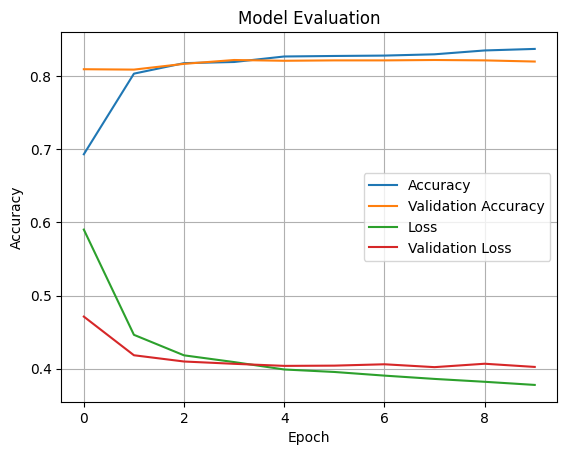

In [ ]:
plot_hist(history)

In [ ]:
# prediction
X_test = df_test['text'].values
predictions_prob = model_use.predict(X_test)
predictions = tf.round(predictions_prob)

102/102 [==============================] - 2s 15ms/step


In [ ]:
submission = pd.read_csv('/content/kaggle_data/sample_submission.csv')
submission['target'] = predictions
submission['target'] =submission['target'].astype(int)
submission['id'] = df_test.index
submission.to_csv('submission.csv', index=False)
submission.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1


In [ ]:
!kaggle competitions submit -c nlp-getting-started -f /content/submission.csv -m "USE without tokenization"

100% 22.2k/22.2k [00:00<00:00, 46.0kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets

kaggle: 0.81182

# USE as baseline model and train BiLSTM model (0.80386)

In [ ]:
def get_tfhub_model(model_link, model_name, model_trainable=False):
    return hub.KerasLayer(model_link,
                          trainable=model_trainable,
                          name=model_name)

encoder_link = 'https://tfhub.dev/google/universal-sentence-encoder/4'
encoder_name = 'universal_sentence_encoder'
encoder_trainable=False # set trainable to False for inference-only
encoder = get_tfhub_model(encoder_link, encoder_name, model_trainable=encoder_trainable)

In [ ]:
from tensorflow.keras import layers
class CFG:
    SEED = 768
    BATCH_SIZE = 32
    EPOCHS = 10

def build_baseline_model():
    # Define kernel initializer & input layer
    initializer = tf.keras.initializers.HeNormal(seed=CFG.SEED)
    text_input = layers.Input(shape=[], dtype=tf.string, name='text_text_input')

    # Generate Embeddings
    # review_embedding = encoder(review_input)
    text_embedding = encoder(text_input)

    # Feed Embeddings to a Bidirectional LSTM
    expand_layer = layers.Lambda(lambda embed: tf.expand_dims(embed, axis=1))(text_embedding)
    bi_lstm = layers.Bidirectional(layers.LSTM(128, kernel_initializer=initializer),
                                   name='bidirection_lstm')(expand_layer)

    # Feed LSTM output to classification head
    dropout_layer = layers.Dropout(0.25)(bi_lstm)
    dense_layer = Dense(16, activation="relu")(dropout_layer)
    dense_layer2 = Dense(16, activation="relu")(dense_layer)
    output = Dense(1, activation="sigmoid")(dense_layer2)

    return tf.keras.Model(inputs=text_input, outputs=output,
                          name='use_model')

In [ ]:
from sklearn.model_selection import train_test_split
X, y = df_train['text'].values, df_train['target'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)
X.shape, y.shape

((7613,), (7613,))

In [ ]:
X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.string)
X_val_tf = tf.convert_to_tensor(X_val, dtype=tf.string)

In [ ]:
print(type(X_train_tf))

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [ ]:
# Build model
model = build_baseline_model()

# View summary of model
model.summary()

Model: "use_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_text_input (InputLaye  [(None,)]                 0         
 r)                                                              
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 lambda_4 (Lambda)           (None, 1, 512)            0         
                                                                 
 bidirection_lstm (Bidirect  (None, 256)               656384    
 ional)                                                          
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                         

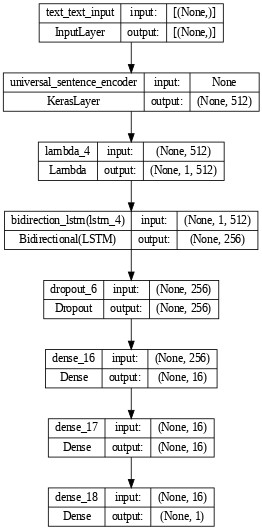

In [ ]:
# Explore model visually
from tensorflow.keras.utils import plot_model
plot_model(
    model, dpi=60,
    show_shapes=True,
    expand_nested=True
)

In [ ]:
# Define Callbacks and Metrics for Model Training
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    factor=0.1,
    verbose=1)

CALLBACKS = [early_stopping_callback, reduce_lr_callback]
METRICS = ['accuracy',tf.keras.metrics.AUC()]

In [ ]:
# compile
tf.random.set_seed(CFG.SEED)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=METRICS
)

In [ ]:
%%time
tf.random.set_seed(CFG.SEED)
history = model.fit(X_train_tf, y_train,
                        epochs = 10,
                        validation_data=(X_val_tf, y_val))

Epoch 1/10
179/179 [==============================] - 18s 57ms/step - loss: 0.5229 - accuracy: 0.7742 - auc_3: 0.8227 - val_loss: 0.4332 - val_accuracy: 0.8083 - val_auc_3: 0.8733
Epoch 2/10
179/179 [==============================] - 5s 26ms/step - loss: 0.4237 - accuracy: 0.8121 - auc_3: 0.8763 - val_loss: 0.4340 - val_accuracy: 0.8078 - val_auc_3: 0.8726
Epoch 3/10
179/179 [==============================] - 5s 27ms/step - loss: 0.4124 - accuracy: 0.8150 - auc_3: 0.8836 - val_loss: 0.4321 - val_accuracy: 0.8030 - val_auc_3: 0.8771
Epoch 4/10
179/179 [==============================] - 6s 32ms/step - loss: 0.4036 - accuracy: 0.8199 - auc_3: 0.8882 - val_loss: 0.4322 - val_accuracy: 0.8067 - val_auc_3: 0.8721
Epoch 5/10
179/179 [==============================] - 6s 32ms/step - loss: 0.3966 - accuracy: 0.8219 - auc_3: 0.8927 - val_loss: 0.4390 - val_accuracy: 0.8099 - val_auc_3: 0.8754
Epoch 6/10
179/179 [==============================] - 5s 29ms/step - loss: 0.3898 - accuracy: 0.8243 - a

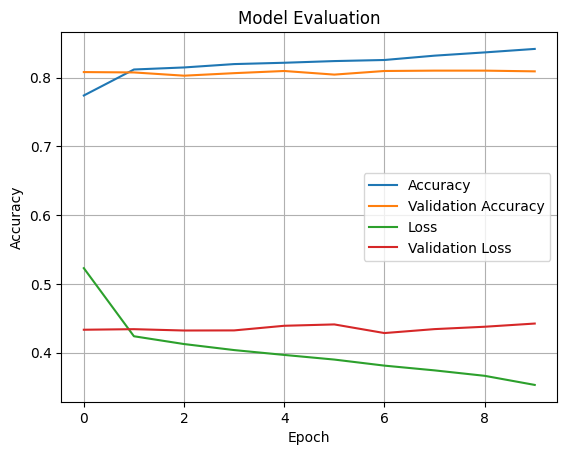

In [ ]:
plot_hist(history)

In [ ]:
# prediction
X_test = df_test['text'].values
X_test_tf = tf.convert_to_tensor(X_test, dtype=tf.string)
predictions_prob = model.predict(X_test_tf)
predictions = tf.round(predictions_prob)

102/102 [==============================] - 4s 21ms/step


In [ ]:
submission = pd.read_csv('/content/kaggle_data/sample_submission.csv')
submission['target'] = predictions
submission['target'] =submission['target'].astype(int)
submission['id'] = df_test.index
submission.to_csv('submission2.csv', index=False)
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [ ]:
!kaggle competitions submit -c nlp-getting-started -f /content/submission2.csv -m "USE with biLSTM"

100% 22.2k/22.2k [00:00<00:00, 23.6kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets

0.80386